# EDA: JAXA衛星データ × クマ目撃情報の相関分析

## 目的
JAXA Earth APIから取得した衛星データ（NDVI, DEM, FNF, GSMaP, LST, Landcover）と
クマ目撃データの間に相関があるかを調べ、予測モデルの特徴量候補を選定する。

## 分析内容
1. **目撃データの基本統計** - 時間・空間分布
2. **時系列相関** - 月別目撃件数 vs NDVI/LST/GSMaP の月次変化
3. **空間相関** - 目撃地点の標高・森林率・土地被覆分布
4. **NDVI変化率と目撃の関係** - 植生活性変化がクマ出没に影響するか

In [1]:
import sys
sys.path.insert(0, '..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pathlib import Path
from config import BBOX, JAXA_DIR, SIGHTINGS_CSV

plt.rcParams['font.family'] = 'Hiragino Sans'
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

print(f"BBOX: {BBOX}")
print(f"JAXA_DIR: {JAXA_DIR}")
print(f"Sightings CSV: {SIGHTINGS_CSV}")

BBOX: [138.9, 35.55, 139.35, 35.95]
JAXA_DIR: /Users/naoya.yasuda/Downloads/CU_JAXA/notebooks/../data/raw/jaxa
Sightings CSV: /Users/naoya.yasuda/Downloads/CU_JAXA/notebooks/../data/tukinowaguma_source1120.csv


## 1. 目撃データの読み込みと基本統計

In [2]:
# 目撃データ読み込み
df = pd.read_csv(SIGHTINGS_CSV, encoding='utf-8-sig')
df['date'] = pd.to_datetime(df['date'])
df['year_month'] = df['date'].dt.to_period('M')
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

print(f"総目撃件数: {len(df)}")
print(f"期間: {df['date'].min()} ~ {df['date'].max()}")
print(f"緯度範囲: {df['lat'].min():.4f} ~ {df['lat'].max():.4f}")
print(f"経度範囲: {df['lon'].min():.4f} ~ {df['lon'].max():.4f}")
print(f"\n種別内訳:")
print(df['sightings, traces, etc.'].value_counts())
print(f"\n精度内訳:")
print(df['accuracy'].value_counts())
df.head()

総目撃件数: 790
期間: 2023-04-01 00:00:00 ~ 2025-11-18 00:00:00
緯度範囲: 35.6018 ~ 35.8948
経度範囲: 138.9461 ~ 139.2971

種別内訳:
sightings, traces, etc.
witness          437
trace            254
photographing     68
capture           31
Name: count, dtype: int64

精度内訳:
accuracy
high      423
middle    259
low       108
Name: count, dtype: int64


,lat,lon,number,date,accuracy,"sightings, traces, etc.",year_month,month,year
0,35.670214,139.231496,1,2023-04-01,middle,witness,2023-04,4,2023
1,35.688220,139.173431,2,2023-04-04,middle,witness,2023-04,4,2023
2,35.763455,139.180512,3,2023-04-11,middle,witness,2023-04,4,2023
3,35.638927,139.224200,4,2023-04-18,middle,witness,2023-04,4,2023
4,35.650863,139.192743,5,2023-05-01,middle,trace,2023-05,5,2023


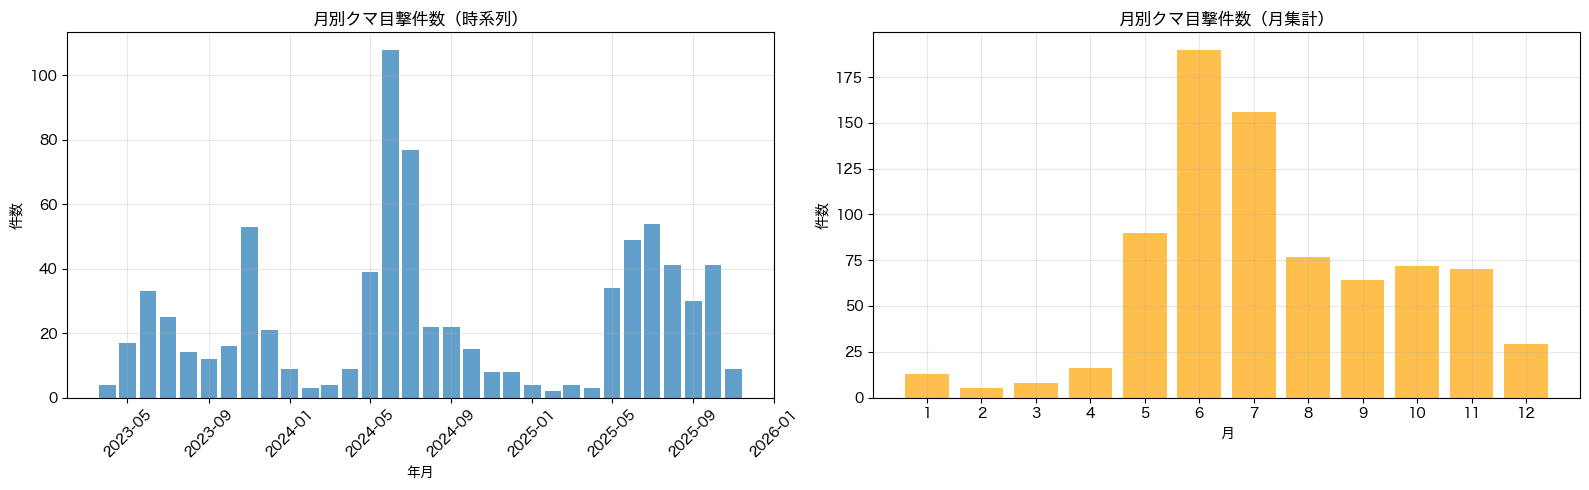

月別件数:
month
1      13
2       5
3       8
4      16
5      90
6     190
7     156
8      77
9      64
10     72
11     70
12     29


In [3]:
# 月別目撃件数
monthly_counts = df.groupby('year_month').size().reset_index(name='count')
monthly_counts['date'] = monthly_counts['year_month'].dt.to_timestamp()

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# 月別時系列
axes[0].bar(monthly_counts['date'], monthly_counts['count'], width=25, alpha=0.7)
axes[0].set_title('月別クマ目撃件数（時系列）')
axes[0].set_xlabel('年月')
axes[0].set_ylabel('件数')
axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
axes[0].tick_params(axis='x', rotation=45)

# 月別集計（全年合計）
month_agg = df.groupby('month').size()
axes[1].bar(month_agg.index, month_agg.values, alpha=0.7, color='orange')
axes[1].set_title('月別クマ目撃件数（月集計）')
axes[1].set_xlabel('月')
axes[1].set_ylabel('件数')
axes[1].set_xticks(range(1, 13))

plt.tight_layout()
plt.show()

print("月別件数:")
print(month_agg.to_string())

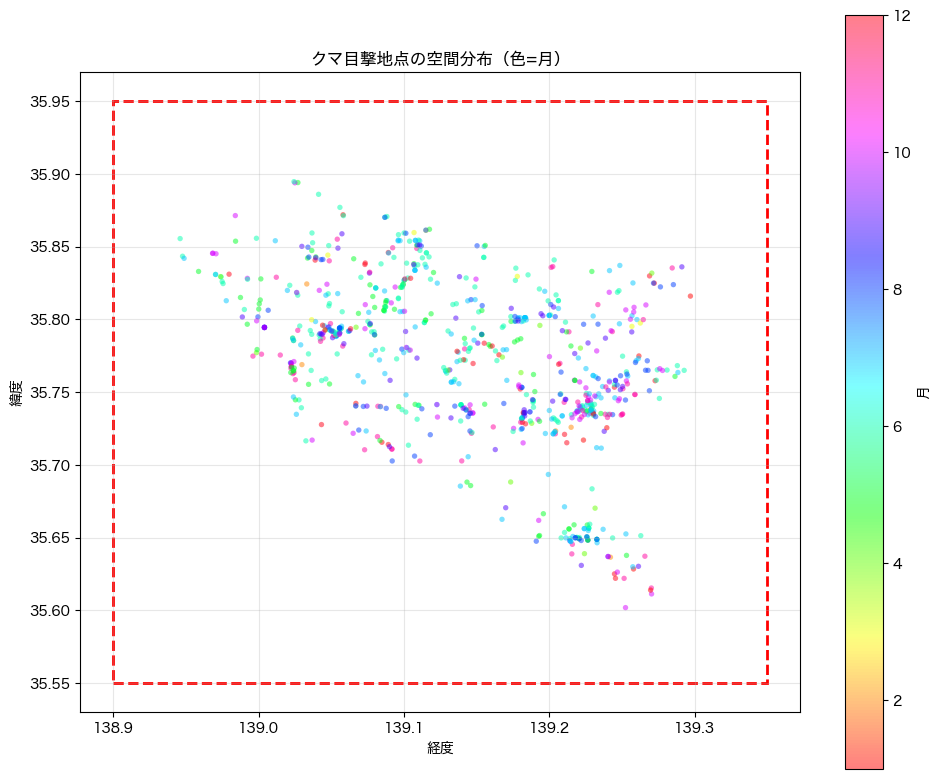

In [4]:
# 目撃地点の空間分布
fig, ax = plt.subplots(figsize=(10, 8))
scatter = ax.scatter(df['lon'], df['lat'], c=df['month'], cmap='hsv',
                     alpha=0.5, s=15, edgecolors='none')
plt.colorbar(scatter, label='月')
ax.set_title('クマ目撃地点の空間分布（色=月）')
ax.set_xlabel('経度')
ax.set_ylabel('緯度')
# BBOX枠
from matplotlib.patches import Rectangle
rect = Rectangle((BBOX[0], BBOX[1]), BBOX[2]-BBOX[0], BBOX[3]-BBOX[1],
                  linewidth=2, edgecolor='red', facecolor='none', linestyle='--')
ax.add_patch(rect)
ax.set_aspect('equal')
plt.tight_layout()
plt.show()

## 2. 衛星データの読み込み

In [5]:
import json

def load_jaxa_data(name):
    """JAXAデータを読み込む。npyファイルのリストとメタデータを返す"""
    data_dir = JAXA_DIR / name
    meta_path = data_dir / 'metadata.json'

    with open(meta_path) as f:
        meta = json.load(f)

    images = []
    for i in range(meta['n_images']):
        npy_path = data_dir / f"{name}_{i:03d}.npy"
        images.append(np.load(npy_path))

    return images, meta


def generate_monthly_dates(start, end):
    """開始月~終了月のPeriodリストを生成"""
    return pd.period_range(start=start[:7], end=end[:7], freq='M')


# 全データ読み込み
ndvi_imgs, ndvi_meta = load_jaxa_data('ndvi_monthly')
dem_imgs, dem_meta = load_jaxa_data('dem')
fnf_imgs, fnf_meta = load_jaxa_data('fnf')
gsmap_imgs, gsmap_meta = load_jaxa_data('gsmap_monthly')
lst_imgs, lst_meta = load_jaxa_data('lst_monthly')
lc_imgs, lc_meta = load_jaxa_data('landcover')

# 月ラベル生成
ndvi_months = generate_monthly_dates('2023-10', '2025-09')  # 24ヶ月
gsmap_months = generate_monthly_dates('2023-10', '2025-09')  # 24ヶ月
lst_months = generate_monthly_dates('2023-10', '2025-05')    # 20ヶ月

print(f"NDVI: {len(ndvi_imgs)} images, shape={ndvi_imgs[0].shape}")
print(f"DEM: {len(dem_imgs)} images, shape={dem_imgs[0].shape}")
print(f"FNF: {len(fnf_imgs)} images, shape={fnf_imgs[0].shape}")
print(f"GSMaP: {len(gsmap_imgs)} images, shape={gsmap_imgs[0].shape}")
print(f"LST: {len(lst_imgs)} images, shape={lst_imgs[0].shape}")
print(f"Landcover: {len(lc_imgs)} images, shape={lc_imgs[0].shape}")

NDVI: 24 images, shape=(8, 9, 1)
DEM: 1 images, shape=(35, 40, 1)
FNF: 1 images, shape=(35, 40, 1)
GSMaP: 24 images, shape=(3, 4, 1)
LST: 20 images, shape=(8, 9, 1)
Landcover: 1 images, shape=(8, 9, 1)


In [6]:
# 各データの領域平均時系列を作成
ndvi_mean = [np.nanmean(img) for img in ndvi_imgs]
gsmap_mean = [np.nanmean(img) for img in gsmap_imgs]
lst_mean = [np.nanmean(img) for img in lst_imgs]  # ケルビン
lst_celsius = [t - 273.15 for t in lst_mean]  # 摂氏に変換

# NDVI変化率（前月差分）
ndvi_diff = [ndvi_mean[i] - ndvi_mean[i-1] for i in range(1, len(ndvi_mean))]

print("NDVI 月次平均:", [f"{v:.3f}" for v in ndvi_mean])
print(f"\nGSMaP 月次平均 (mm/h): {[f'{v:.4f}' for v in gsmap_mean]}")
print(f"\nLST 月次平均 (℃): {[f'{v:.1f}' for v in lst_celsius]}")

NDVI 月次平均: ['0.825', '0.726', '0.692', '0.676', '0.634', '0.651', '0.677', '0.840', '0.883', '0.857', '0.864', '0.859', '0.826', '0.755', '0.683', '0.668', '0.659', '0.649', '0.688', '0.810', '0.857', '0.865', '0.877', '0.853']

GSMaP 月次平均 (mm/h): ['0.1356', '0.0726', '0.0283', '0.0490', '0.1304', '0.2012', '0.1340', '0.2537', '0.3877', '0.1450', '0.5539', '0.1328', '0.2885', '0.1492', '0.0006', '0.0277', '0.0129', '0.1869', '0.1738', '0.3232', '0.1693', '0.2408', '0.0956', '0.3707']

LST 月次平均 (℃): ['18.9', '14.8', '8.9', '6.7', '7.7', '11.5', '20.0', '21.6', '23.9', '29.7', '28.5', '27.0', '18.9', '12.9', '6.9', '5.4', '6.1', '12.7', '17.1', '19.2']


## 3. 時系列相関分析: 月別目撃件数 vs 衛星データ

In [7]:
# 衛星データ期間内（2023-10 ~ 2025-09）の目撃データのみ抽出
df_period = df[(df['date'] >= '2023-10-01') & (df['date'] < '2025-10-01')].copy()
print(f"衛星データ期間内の目撃件数: {len(df_period)} / {len(df)}")

# 月別目撃件数（衛星データの全期間をカバー）
all_months = pd.period_range('2023-10', '2025-09', freq='M')
sighting_monthly = df_period.groupby('year_month').size()
sighting_monthly = sighting_monthly.reindex(all_months, fill_value=0)

print(f"\n月別目撃件数（衛星データ期間）:")
for m, c in sighting_monthly.items():
    print(f"  {m}: {c}")

衛星データ期間内の目撃件数: 635 / 790

月別目撃件数（衛星データ期間）:
  2023-10: 16
  2023-11: 53
  2023-12: 21
  2024-01: 9
  2024-02: 3
  2024-03: 4
  2024-04: 9
  2024-05: 39
  2024-06: 108
  2024-07: 77
  2024-08: 22
  2024-09: 22
  2024-10: 15
  2024-11: 8
  2024-12: 8
  2025-01: 4
  2025-02: 2
  2025-03: 4
  2025-04: 3
  2025-05: 34
  2025-06: 49
  2025-07: 54
  2025-08: 41
  2025-09: 30


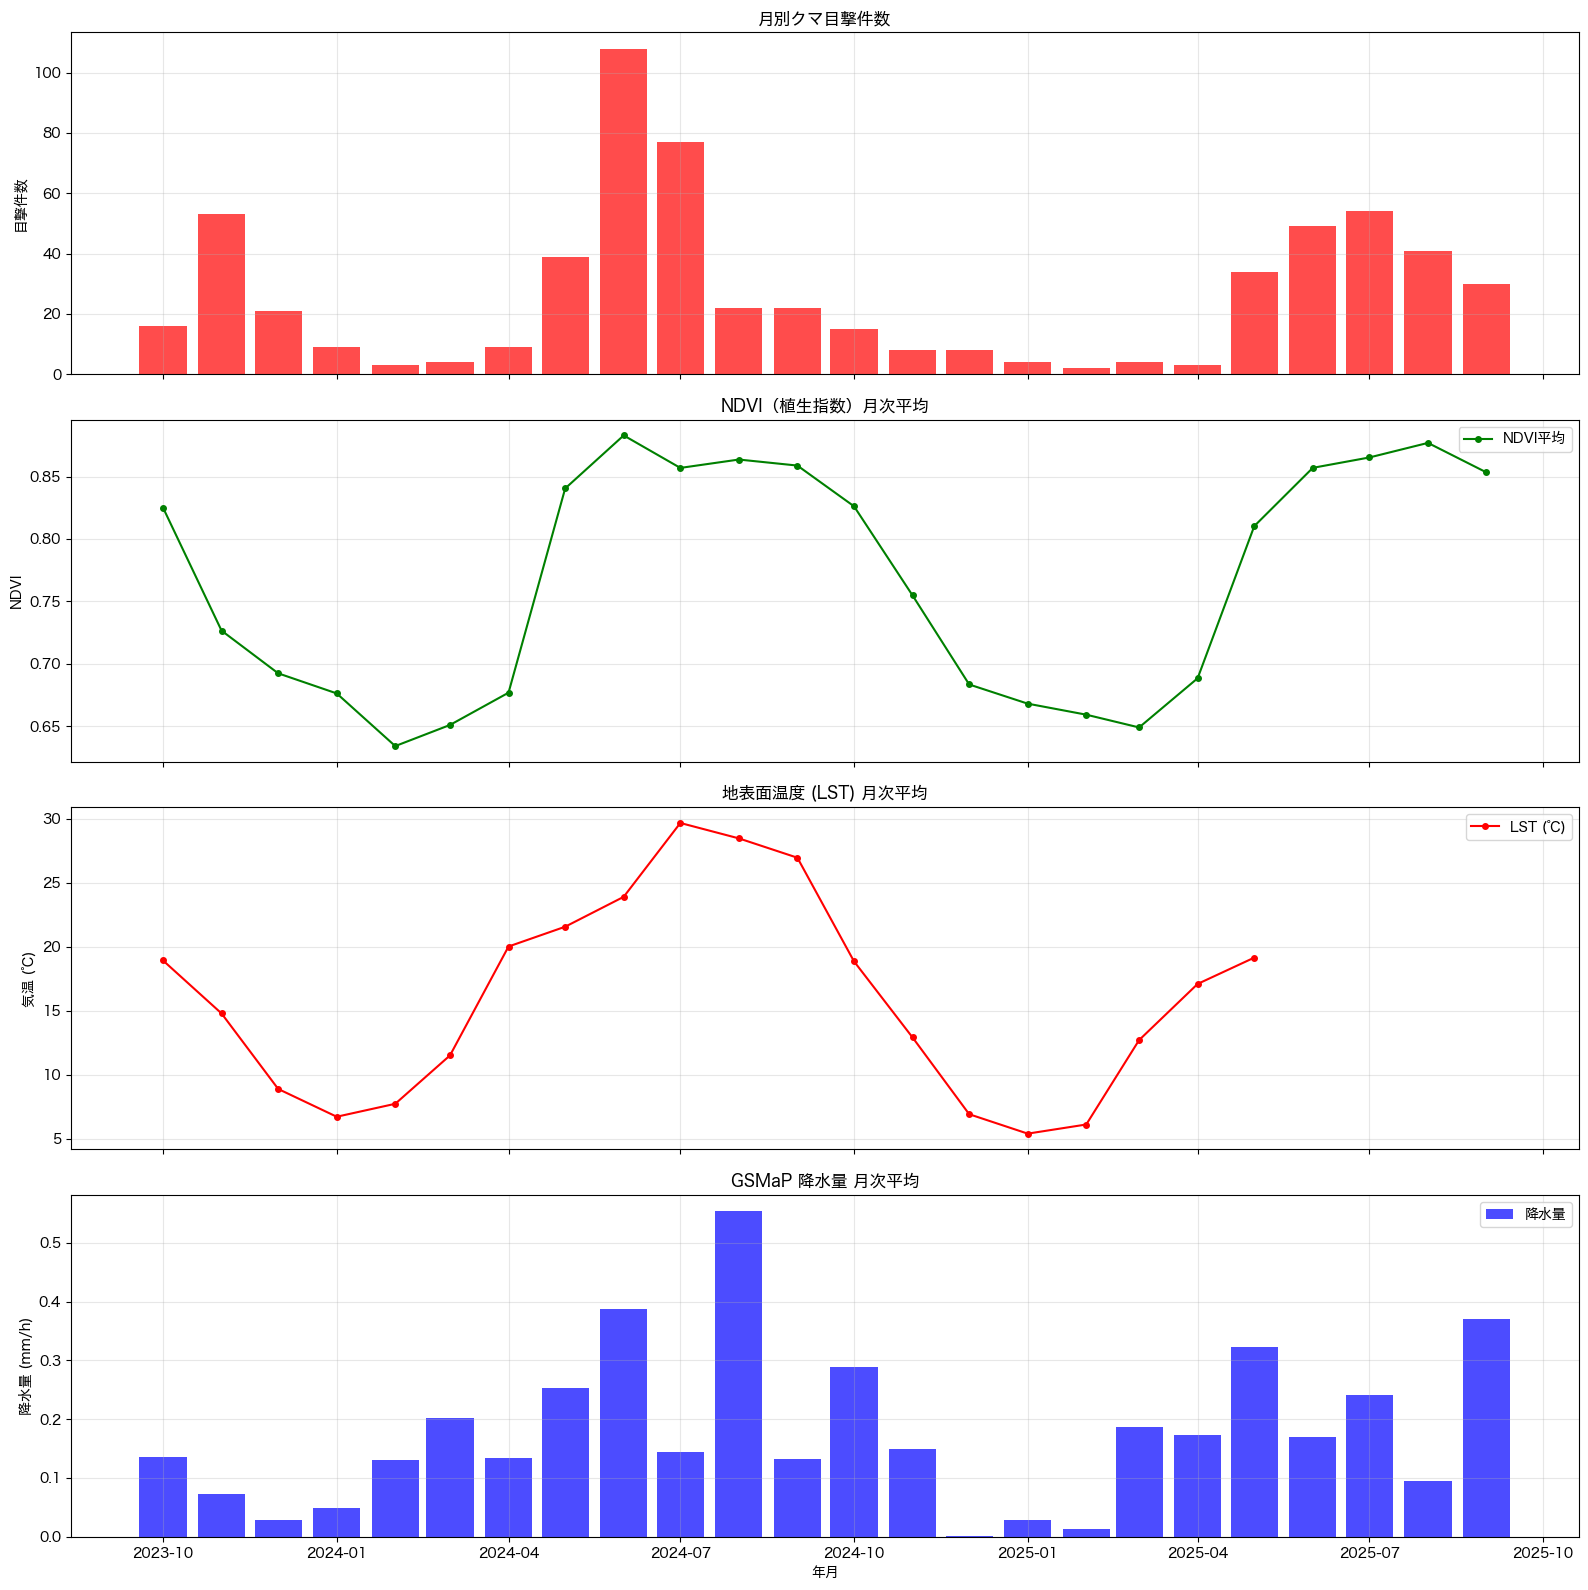

In [8]:
# 時系列の可視化: 目撃件数 vs NDVI / LST / GSMaP
fig, axes = plt.subplots(4, 1, figsize=(16, 16), sharex=True)

x_dates = all_months.to_timestamp()

# 目撃件数
axes[0].bar(x_dates, sighting_monthly.values, width=25, alpha=0.7, color='red')
axes[0].set_ylabel('目撃件数')
axes[0].set_title('月別クマ目撃件数')

# NDVI
axes[1].plot(x_dates, ndvi_mean, 'g-o', markersize=4, label='NDVI平均')
axes[1].set_ylabel('NDVI')
axes[1].set_title('NDVI（植生指数）月次平均')
axes[1].legend()

# LST（20ヶ月のみ）
lst_dates = lst_months.to_timestamp()
axes[2].plot(lst_dates, lst_celsius, 'r-o', markersize=4, label='LST (℃)')
axes[2].set_ylabel('気温 (℃)')
axes[2].set_title('地表面温度 (LST) 月次平均')
axes[2].legend()

# GSMaP
axes[3].bar(x_dates, gsmap_mean, width=25, alpha=0.7, color='blue', label='降水量')
axes[3].set_ylabel('降水量 (mm/h)')
axes[3].set_title('GSMaP 降水量 月次平均')
axes[3].set_xlabel('年月')
axes[3].legend()

for ax in axes:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.tight_layout()
plt.show()

In [9]:
from scipy import stats

# 相関係数の計算
sightings_arr = sighting_monthly.values.astype(float)

# NDVI vs 目撃件数（24ヶ月）
r_ndvi, p_ndvi = stats.pearsonr(sightings_arr, ndvi_mean)
r_ndvi_s, p_ndvi_s = stats.spearmanr(sightings_arr, ndvi_mean)

# NDVI変化率 vs 目撃件数（23ヶ月、1ヶ月ズレ）
r_ndvi_diff, p_ndvi_diff = stats.pearsonr(sightings_arr[1:], ndvi_diff)

# GSMaP vs 目撃件数（24ヶ月）
r_gsmap, p_gsmap = stats.pearsonr(sightings_arr, gsmap_mean)
r_gsmap_s, p_gsmap_s = stats.spearmanr(sightings_arr, gsmap_mean)

# LST vs 目撃件数（20ヶ月のみ）
sightings_lst = sighting_monthly[:20].values.astype(float)
r_lst, p_lst = stats.pearsonr(sightings_lst, lst_celsius)
r_lst_s, p_lst_s = stats.spearmanr(sightings_lst, lst_celsius)

print("=" * 60)
print("月別目撃件数 vs 衛星データ 相関分析")
print("=" * 60)
print(f"{'指標':<25} {'Pearson r':>10} {'p値':>10} {'Spearman r':>12} {'p値':>10}")
print("-" * 70)
print(f"{'NDVI平均':<25} {r_ndvi:>10.4f} {p_ndvi:>10.4f} {r_ndvi_s:>12.4f} {p_ndvi_s:>10.4f}")
print(f"{'NDVI変化率(前月差)':<25} {r_ndvi_diff:>10.4f} {p_ndvi_diff:>10.4f}")
print(f"{'GSMaP降水量':<25} {r_gsmap:>10.4f} {p_gsmap:>10.4f} {r_gsmap_s:>12.4f} {p_gsmap_s:>10.4f}")
print(f"{'LST気温(℃)':<25} {r_lst:>10.4f} {p_lst:>10.4f} {r_lst_s:>12.4f} {p_lst_s:>10.4f}")
print("\n※ p < 0.05 で統計的に有意")

月別目撃件数 vs 衛星データ 相関分析
指標                         Pearson r         p値   Spearman r         p値
----------------------------------------------------------------------
NDVI平均                        0.6925     0.0002       0.8389     0.0000
NDVI変化率(前月差)                  0.2114     0.3330
GSMaP降水量                      0.3509     0.0927       0.3776     0.0689
LST気温(℃)                      0.5867     0.0065       0.7300     0.0003

※ p < 0.05 で統計的に有意


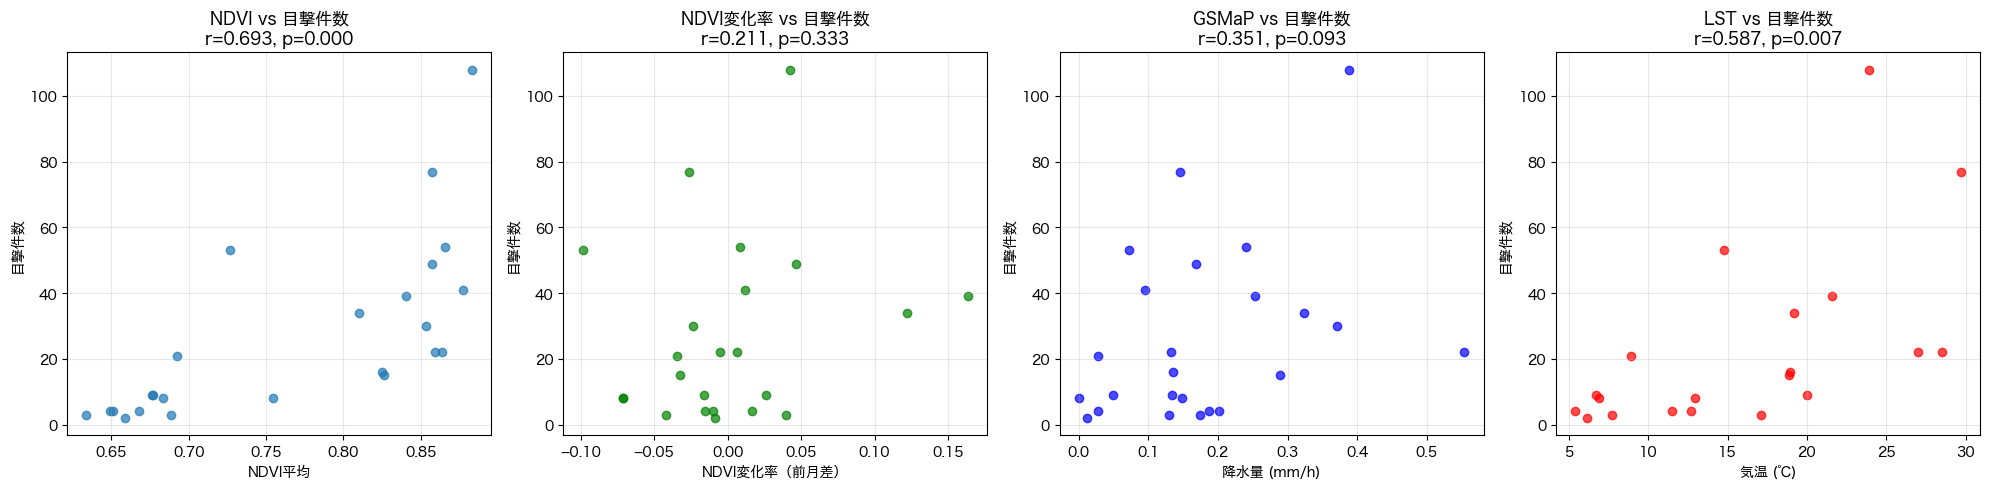

In [10]:
# 散布図: 目撃件数 vs 各衛星データ
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# NDVI vs 目撃
axes[0].scatter(ndvi_mean, sightings_arr, alpha=0.7)
axes[0].set_xlabel('NDVI平均')
axes[0].set_ylabel('目撃件数')
axes[0].set_title(f'NDVI vs 目撃件数\nr={r_ndvi:.3f}, p={p_ndvi:.3f}')

# NDVI変化率 vs 目撃
axes[1].scatter(ndvi_diff, sightings_arr[1:], alpha=0.7, color='green')
axes[1].set_xlabel('NDVI変化率（前月差）')
axes[1].set_ylabel('目撃件数')
axes[1].set_title(f'NDVI変化率 vs 目撃件数\nr={r_ndvi_diff:.3f}, p={p_ndvi_diff:.3f}')

# GSMaP vs 目撃
axes[2].scatter(gsmap_mean, sightings_arr, alpha=0.7, color='blue')
axes[2].set_xlabel('降水量 (mm/h)')
axes[2].set_ylabel('目撃件数')
axes[2].set_title(f'GSMaP vs 目撃件数\nr={r_gsmap:.3f}, p={p_gsmap:.3f}')

# LST vs 目撃
axes[3].scatter(lst_celsius, sightings_lst, alpha=0.7, color='red')
axes[3].set_xlabel('気温 (℃)')
axes[3].set_ylabel('目撃件数')
axes[3].set_title(f'LST vs 目撃件数\nr={r_lst:.3f}, p={p_lst:.3f}')

plt.tight_layout()
plt.show()

## 4. 空間分析: 目撃地点の衛星データ値

In [11]:
def latlon_to_pixel(lat, lon, bbox, shape):
    """緯度経度をラスタのピクセル座標に変換する
    
    Args:
        lat, lon: 緯度経度
        bbox: [west, south, east, north]
        shape: (rows, cols, bands) - ラスタの形状
    
    Returns:
        (row, col) ピクセル座標。範囲外ならNone
    """
    west, south, east, north = bbox
    rows, cols = shape[0], shape[1]
    
    # 正規化
    x_frac = (lon - west) / (east - west)
    y_frac = (north - lat) / (north - south)  # 上が北
    
    col = int(x_frac * cols)
    row = int(y_frac * rows)
    
    if 0 <= row < rows and 0 <= col < cols:
        return row, col
    return None


# テスト: 中心点
center_lat = (BBOX[1] + BBOX[3]) / 2
center_lon = (BBOX[0] + BBOX[2]) / 2
print(f"Center: ({center_lat:.2f}, {center_lon:.2f})")
print(f"DEM pixel: {latlon_to_pixel(center_lat, center_lon, BBOX, dem_imgs[0].shape)}")
print(f"NDVI pixel: {latlon_to_pixel(center_lat, center_lon, BBOX, ndvi_imgs[0].shape)}")

Center: (35.75, 139.12)
DEM pixel: (17, 20)
NDVI pixel: (4, 4)


In [12]:
# 各目撃地点のDEM（標高）値を取得
dem = dem_imgs[0][:, :, 0]  # (35, 40)

elevations = []
for _, row in df.iterrows():
    px = latlon_to_pixel(row['lat'], row['lon'], BBOX, dem_imgs[0].shape)
    if px is not None:
        elevations.append(dem[px[0], px[1]])
    else:
        elevations.append(np.nan)

df['elevation'] = elevations

print(f"標高が取得できた件数: {df['elevation'].notna().sum()} / {len(df)}")
print(f"標高統計:")
print(df['elevation'].describe())

標高が取得できた件数: 790 / 790
標高統計:
count     790.000000
mean      609.422791
std       347.528595
min       131.000000
25%       329.000000
50%       520.000000
75%       777.000000
max      1998.000000
Name: elevation, dtype: float64


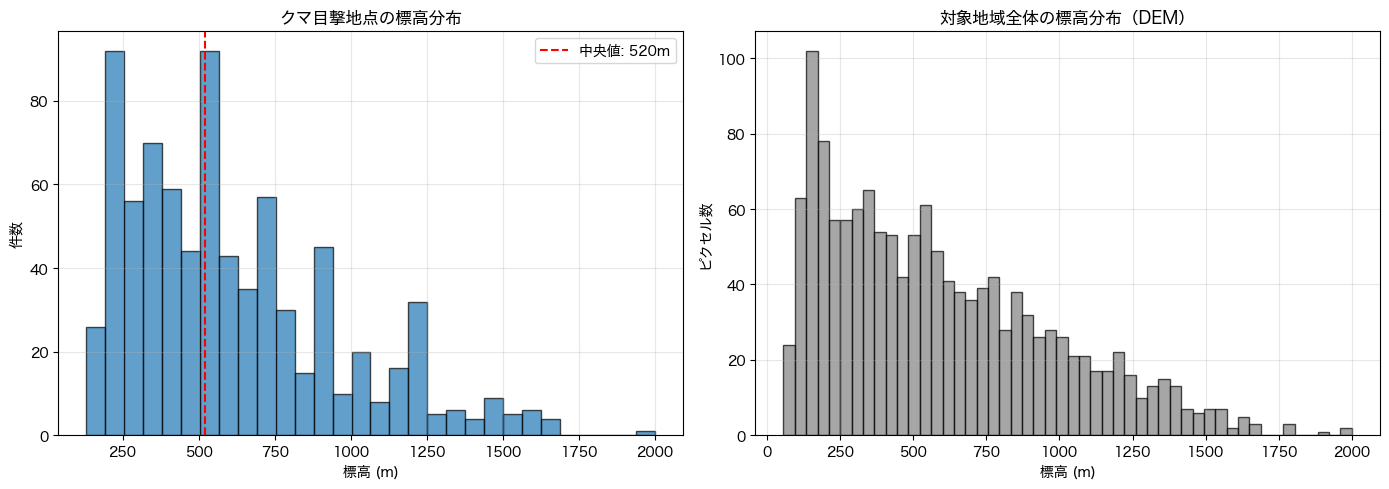

In [13]:
# 標高分布のヒストグラム
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 目撃地点の標高分布
axes[0].hist(df['elevation'].dropna(), bins=30, alpha=0.7, edgecolor='black')
axes[0].set_title('クマ目撃地点の標高分布')
axes[0].set_xlabel('標高 (m)')
axes[0].set_ylabel('件数')
axes[0].axvline(df['elevation'].median(), color='red', linestyle='--',
                label=f'中央値: {df["elevation"].median():.0f}m')
axes[0].legend()

# DEM全体のヒストグラム（比較用）
axes[1].hist(dem.flatten(), bins=50, alpha=0.7, edgecolor='black', color='gray')
axes[1].set_title('対象地域全体の標高分布（DEM）')
axes[1].set_xlabel('標高 (m)')
axes[1].set_ylabel('ピクセル数')

plt.tight_layout()
plt.show()

In [14]:
# FNF（森林・非森林）値を取得
# FNF: 1=森林, 2=非森林, 3=水域, 4=データなし
fnf = fnf_imgs[0][:, :, 0]  # (35, 40)

fnf_values = []
for _, row in df.iterrows():
    px = latlon_to_pixel(row['lat'], row['lon'], BBOX, fnf_imgs[0].shape)
    if px is not None:
        fnf_values.append(int(fnf[px[0], px[1]]))
    else:
        fnf_values.append(np.nan)

df['fnf'] = fnf_values

fnf_labels = {1: '森林', 2: '非森林', 3: '水域', 4: 'データなし'}
df['fnf_label'] = df['fnf'].map(fnf_labels)

print("目撃地点のFNF分類:")
print(df['fnf_label'].value_counts())
print(f"\n森林での目撃率: {(df['fnf'] == 1).sum() / df['fnf'].notna().sum() * 100:.1f}%")

目撃地点のFNF分類:
fnf_label
森林       765
データなし     13
水域        12
Name: count, dtype: int64

森林での目撃率: 96.8%


In [15]:
# Landcover（土地被覆）値を取得
# Copernicus LCCS分類コード
lc = lc_imgs[0][:, :, 0]  # (8, 9)

lccs_labels = {
    0: 'No data', 10: '農地(灌漑)', 11: '農地(灌漑,草本)',
    12: '農地(灌漑,木本)', 20: '農地(天水)', 30: '農地モザイク',
    40: '農地/自然植生モザイク', 50: '常緑広葉樹林(閉)',
    60: '落葉広葉樹林(閉)', 61: '落葉広葉樹林(閉)',
    70: '常緑針葉樹林(閉)', 80: '落葉針葉樹林(閉)',
    90: '混交林(閉)', 100: '混交林(開)', 110: '低木',
    120: '草地', 130: '疎植生', 140: '苔/地衣',
    150: '裸地', 160: '氾濫林', 170: '氾濫低木/草地',
    180: '氾濫植生', 190: '市街地', 200: '裸地',
    210: '水域', 220: '永久雪氷'
}

lc_values = []
for _, row in df.iterrows():
    px = latlon_to_pixel(row['lat'], row['lon'], BBOX, lc_imgs[0].shape)
    if px is not None:
        lc_values.append(int(lc[px[0], px[1]]))
    else:
        lc_values.append(np.nan)

df['landcover'] = lc_values
df['lc_label'] = df['landcover'].map(lccs_labels)

print("目撃地点のLandcover分類:")
print(df['lc_label'].value_counts())

print(f"\nLandcover値の分布:")
print(df['landcover'].value_counts().sort_index())

目撃地点のLandcover分類:
lc_label
常緑針葉樹林(閉)    678
落葉広葉樹林(閉)     73
市街地           39
Name: count, dtype: int64

Landcover値の分布:
landcover
60      73
70     678
190     39
Name: count, dtype: int64


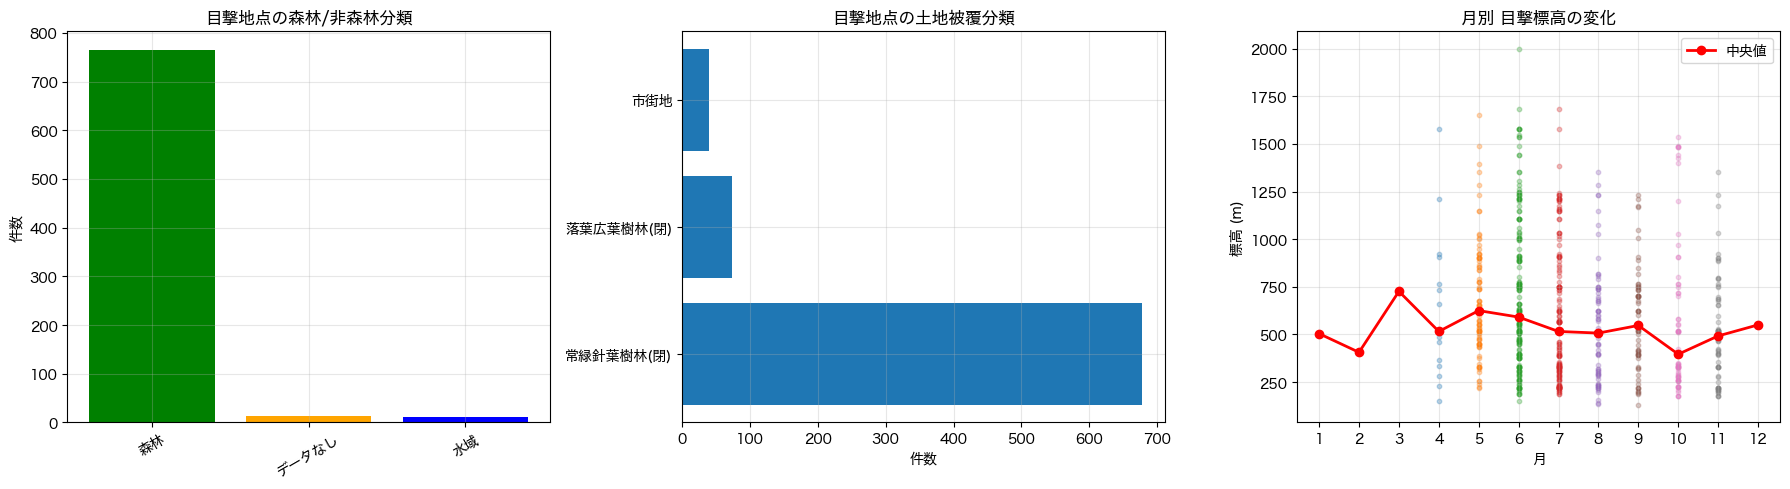

In [16]:
# 空間分析の可視化
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# FNF分布
fnf_counts = df['fnf_label'].value_counts()
axes[0].bar(fnf_counts.index, fnf_counts.values, color=['green', 'orange', 'blue', 'gray'][:len(fnf_counts)])
axes[0].set_title('目撃地点の森林/非森林分類')
axes[0].set_ylabel('件数')
axes[0].tick_params(axis='x', rotation=30)

# Landcover分布
lc_counts = df['lc_label'].value_counts()
axes[1].barh(lc_counts.index, lc_counts.values)
axes[1].set_title('目撃地点の土地被覆分類')
axes[1].set_xlabel('件数')

# 標高 vs 月（季節による標高帯の変化）
for m in [4, 5, 6, 7, 8, 9, 10, 11]:
    elev_m = df[df['month'] == m]['elevation'].dropna()
    if len(elev_m) > 0:
        axes[2].scatter([m] * len(elev_m), elev_m, alpha=0.3, s=10)

# 月別中央値をライン
monthly_elev = df.groupby('month')['elevation'].median()
axes[2].plot(monthly_elev.index, monthly_elev.values, 'r-o', linewidth=2, label='中央値')
axes[2].set_title('月別 目撃標高の変化')
axes[2].set_xlabel('月')
axes[2].set_ylabel('標高 (m)')
axes[2].set_xticks(range(1, 13))
axes[2].legend()

plt.tight_layout()
plt.show()

## 5. NDVI変化率と目撃の関係（空間的）

In [17]:
# 各目撃地点の、その月のNDVI値とNDVI変化率を取得
def get_month_index(date, start='2023-10'):
    """日付からNDVI配列のインデックスを返す"""
    start_period = pd.Period(start, freq='M')
    date_period = pd.Period(date, freq='M')
    idx = (date_period - start_period).n
    return idx if 0 <= idx < 24 else None

ndvi_at_sighting = []
ndvi_diff_at_sighting = []
gsmap_at_sighting = []
lst_at_sighting = []

for _, row in df_period.iterrows():
    midx = get_month_index(row['date'])
    if midx is None:
        ndvi_at_sighting.append(np.nan)
        ndvi_diff_at_sighting.append(np.nan)
        gsmap_at_sighting.append(np.nan)
        lst_at_sighting.append(np.nan)
        continue

    # NDVI
    px_ndvi = latlon_to_pixel(row['lat'], row['lon'], BBOX, ndvi_imgs[0].shape)
    if px_ndvi is not None:
        val = ndvi_imgs[midx][px_ndvi[0], px_ndvi[1], 0]
        ndvi_at_sighting.append(val)
        if midx > 0:
            prev_val = ndvi_imgs[midx-1][px_ndvi[0], px_ndvi[1], 0]
            ndvi_diff_at_sighting.append(val - prev_val)
        else:
            ndvi_diff_at_sighting.append(np.nan)
    else:
        ndvi_at_sighting.append(np.nan)
        ndvi_diff_at_sighting.append(np.nan)

    # GSMaP
    px_gsmap = latlon_to_pixel(row['lat'], row['lon'], BBOX, gsmap_imgs[0].shape)
    if px_gsmap is not None:
        gsmap_at_sighting.append(gsmap_imgs[midx][px_gsmap[0], px_gsmap[1], 0])
    else:
        gsmap_at_sighting.append(np.nan)

    # LST
    if midx < len(lst_imgs):
        px_lst = latlon_to_pixel(row['lat'], row['lon'], BBOX, lst_imgs[0].shape)
        if px_lst is not None:
            lst_at_sighting.append(lst_imgs[midx][px_lst[0], px_lst[1], 0] - 273.15)
        else:
            lst_at_sighting.append(np.nan)
    else:
        lst_at_sighting.append(np.nan)

df_period = df_period.copy()
df_period['ndvi'] = ndvi_at_sighting
df_period['ndvi_diff'] = ndvi_diff_at_sighting
df_period['gsmap'] = gsmap_at_sighting
df_period['lst_celsius'] = lst_at_sighting

print("目撃地点の衛星データ統計:")
print(df_period[['ndvi', 'ndvi_diff', 'gsmap', 'lst_celsius']].describe())

目撃地点の衛星データ統計:


             ndvi   ndvi_diff       gsmap  lst_celsius
count  635.000000  619.000000  635.000000   461.000000
mean     0.833171    0.013896    0.223830    20.381278
std      0.070559    0.078951    0.133601     6.905917
min      0.530500   -0.178700    0.000000     2.589996
25%      0.800300   -0.032800    0.130545    15.809998
50%      0.859200    0.013400    0.173680    20.570007
75%      0.879800    0.049400    0.356127    25.410004
max      0.956200    0.253400    0.563674    35.470001


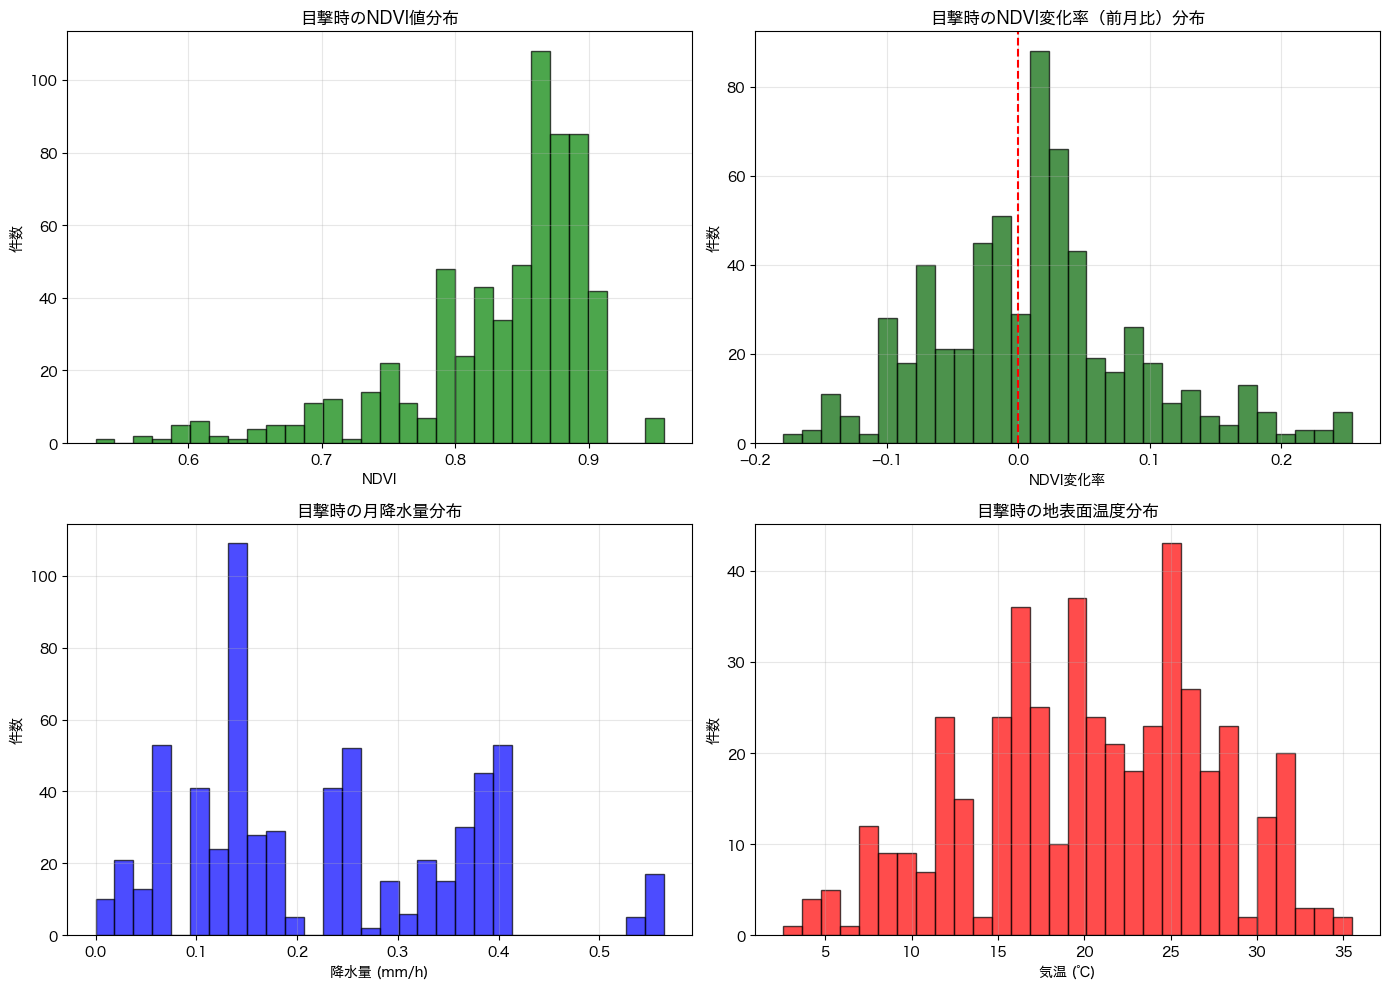

In [18]:
# 目撃時のNDVI / NDVI変化率の分布
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 目撃時のNDVI値分布
axes[0, 0].hist(df_period['ndvi'].dropna(), bins=30, alpha=0.7, edgecolor='black', color='green')
axes[0, 0].set_title('目撃時のNDVI値分布')
axes[0, 0].set_xlabel('NDVI')
axes[0, 0].set_ylabel('件数')

# 目撃時のNDVI変化率分布
axes[0, 1].hist(df_period['ndvi_diff'].dropna(), bins=30, alpha=0.7, edgecolor='black', color='darkgreen')
axes[0, 1].set_title('目撃時のNDVI変化率（前月比）分布')
axes[0, 1].set_xlabel('NDVI変化率')
axes[0, 1].set_ylabel('件数')
axes[0, 1].axvline(0, color='red', linestyle='--')

# 目撃時の降水量分布
axes[1, 0].hist(df_period['gsmap'].dropna(), bins=30, alpha=0.7, edgecolor='black', color='blue')
axes[1, 0].set_title('目撃時の月降水量分布')
axes[1, 0].set_xlabel('降水量 (mm/h)')
axes[1, 0].set_ylabel('件数')

# 目撃時の気温分布
axes[1, 1].hist(df_period['lst_celsius'].dropna(), bins=30, alpha=0.7, edgecolor='black', color='red')
axes[1, 1].set_title('目撃時の地表面温度分布')
axes[1, 1].set_xlabel('気温 (℃)')
axes[1, 1].set_ylabel('件数')

plt.tight_layout()
plt.show()

## 6. ラスタデータの可視化

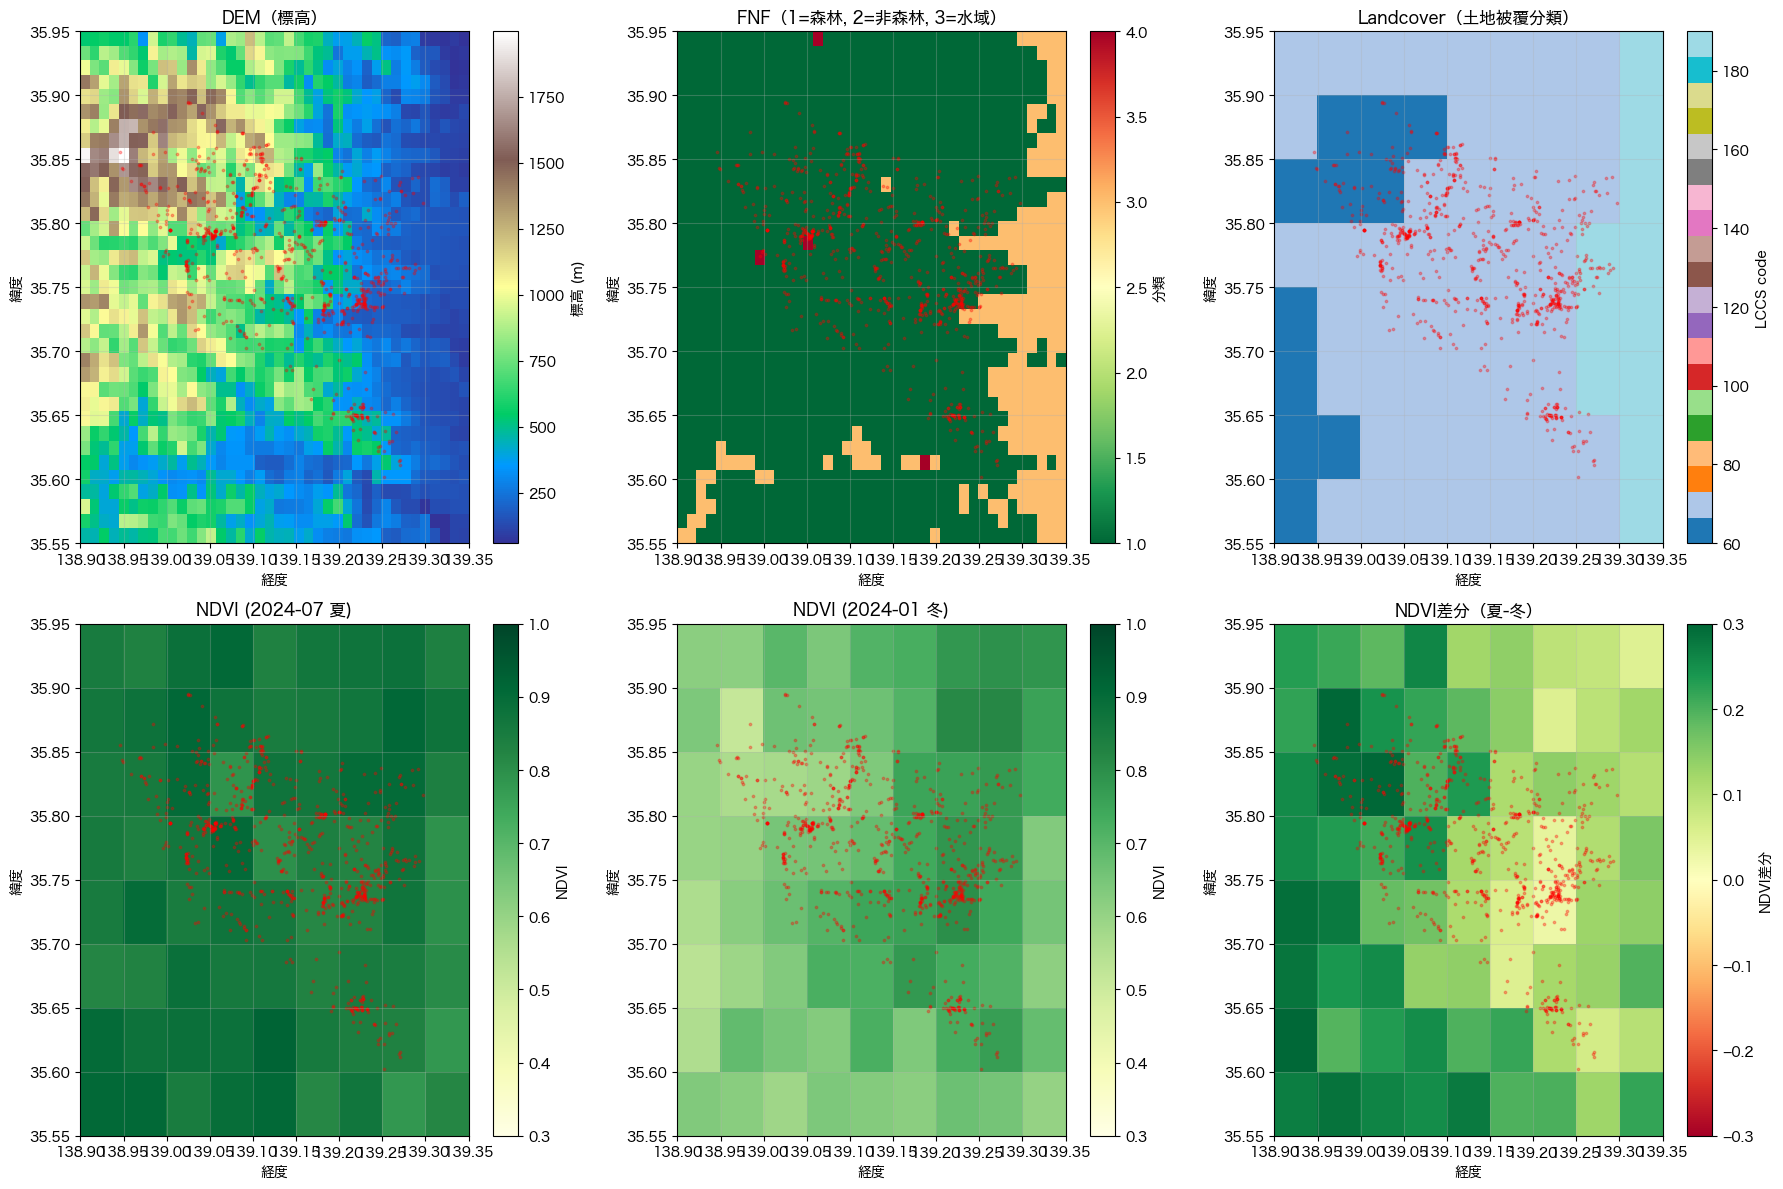

In [19]:
# DEM, FNF, Landcover, NDVI（特定月）の可視化
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

extent = [BBOX[0], BBOX[2], BBOX[1], BBOX[3]]  # [left, right, bottom, top]

# DEM
im0 = axes[0, 0].imshow(dem_imgs[0][:, :, 0], extent=extent, cmap='terrain', aspect='auto')
axes[0, 0].set_title('DEM（標高）')
plt.colorbar(im0, ax=axes[0, 0], label='標高 (m)')

# FNF
im1 = axes[0, 1].imshow(fnf_imgs[0][:, :, 0], extent=extent, cmap='RdYlGn_r',
                          vmin=1, vmax=4, aspect='auto')
axes[0, 1].set_title('FNF（1=森林, 2=非森林, 3=水域）')
plt.colorbar(im1, ax=axes[0, 1], label='分類')

# Landcover
im2 = axes[0, 2].imshow(lc_imgs[0][:, :, 0], extent=extent, cmap='tab20', aspect='auto')
axes[0, 2].set_title('Landcover（土地被覆分類）')
plt.colorbar(im2, ax=axes[0, 2], label='LCCS code')

# NDVI 夏（2024-07, index=9）
im3 = axes[1, 0].imshow(ndvi_imgs[9][:, :, 0], extent=extent, cmap='YlGn',
                          vmin=0.3, vmax=1.0, aspect='auto')
axes[1, 0].set_title('NDVI (2024-07 夏)')
plt.colorbar(im3, ax=axes[1, 0], label='NDVI')

# NDVI 冬（2024-01, index=3）
im4 = axes[1, 1].imshow(ndvi_imgs[3][:, :, 0], extent=extent, cmap='YlGn',
                          vmin=0.3, vmax=1.0, aspect='auto')
axes[1, 1].set_title('NDVI (2024-01 冬)')
plt.colorbar(im4, ax=axes[1, 1], label='NDVI')

# NDVI差分（夏 - 冬）
ndvi_diff_map = ndvi_imgs[9][:, :, 0] - ndvi_imgs[3][:, :, 0]
im5 = axes[1, 2].imshow(ndvi_diff_map, extent=extent, cmap='RdYlGn',
                          vmin=-0.3, vmax=0.3, aspect='auto')
axes[1, 2].set_title('NDVI差分（夏-冬）')
plt.colorbar(im5, ax=axes[1, 2], label='NDVI差分')

# 全パネルに目撃地点をオーバーレイ
for ax in axes.flatten():
    ax.scatter(df['lon'], df['lat'], c='red', s=3, alpha=0.3, label='目撃地点')
    ax.set_xlabel('経度')
    ax.set_ylabel('緯度')

plt.tight_layout()
plt.show()

## 7. 総合分析サマリ

In [20]:
print("=" * 70)
print("EDA結果サマリ: JAXA衛星データ × クマ目撃情報")
print("=" * 70)

print("\n【1. 目撃データの概要】")
print(f"  総件数: {len(df)}")
print(f"  期間: {df['date'].min().strftime('%Y-%m')} ~ {df['date'].max().strftime('%Y-%m')}")
print(f"  ピーク月: {month_agg.idxmax()}月 ({month_agg.max()}件)")
print(f"  目撃種別: {dict(df['sightings, traces, etc.'].value_counts())}")

print("\n【2. 時系列相関（月別集計）】")
print(f"  NDVI vs 目撃件数:       r={r_ndvi:.3f} (p={p_ndvi:.4f})")
print(f"  NDVI変化率 vs 目撃件数: r={r_ndvi_diff:.3f} (p={p_ndvi_diff:.4f})")
print(f"  GSMaP vs 目撃件数:      r={r_gsmap:.3f} (p={p_gsmap:.4f})")
print(f"  LST vs 目撃件数:        r={r_lst:.3f} (p={p_lst:.4f})")

print("\n【3. 空間分析】")
print(f"  目撃地点の標高中央値: {df['elevation'].median():.0f}m")
print(f"  目撃地点の標高範囲: {df['elevation'].min():.0f}m ~ {df['elevation'].max():.0f}m")
forest_pct = (df['fnf'] == 1).sum() / df['fnf'].notna().sum() * 100
print(f"  森林域での目撃率: {forest_pct:.1f}%")
print(f"  土地被覆の最頻値: {df['lc_label'].mode().values[0]}")

print("\n【4. 予測モデルへの特徴量候補】")
features = []
if abs(r_ndvi) > 0.3 or p_ndvi < 0.05:
    features.append(f"  ✓ NDVI値 (r={r_ndvi:.3f})")
if abs(r_ndvi_diff) > 0.3 or p_ndvi_diff < 0.05:
    features.append(f"  ✓ NDVI変化率 (r={r_ndvi_diff:.3f})")
if abs(r_gsmap) > 0.3 or p_gsmap < 0.05:
    features.append(f"  ✓ GSMaP降水量 (r={r_gsmap:.3f})")
if abs(r_lst) > 0.3 or p_lst < 0.05:
    features.append(f"  ✓ LST気温 (r={r_lst:.3f})")
features.append("  ✓ DEM標高（空間的偏りあり）")
features.append("  ✓ FNF森林分類（空間的偏りあり）")
features.append("  ✓ Landcover土地被覆（空間的偏りあり）")
features.append("  ✓ 月（季節性）")

for f in features:
    print(f)

EDA結果サマリ: JAXA衛星データ × クマ目撃情報

【1. 目撃データの概要】
  総件数: 790
  期間: 2023-04 ~ 2025-11
  ピーク月: 6月 (190件)
  目撃種別: {'witness': np.int64(437), 'trace': np.int64(254), 'photographing': np.int64(68), 'capture': np.int64(31)}

【2. 時系列相関（月別集計）】
  NDVI vs 目撃件数:       r=0.693 (p=0.0002)
  NDVI変化率 vs 目撃件数: r=0.211 (p=0.3330)
  GSMaP vs 目撃件数:      r=0.351 (p=0.0927)
  LST vs 目撃件数:        r=0.587 (p=0.0065)

【3. 空間分析】
  目撃地点の標高中央値: 520m
  目撃地点の標高範囲: 131m ~ 1998m
  森林域での目撃率: 96.8%
  土地被覆の最頻値: 常緑針葉樹林(閉)

【4. 予測モデルへの特徴量候補】
  ✓ NDVI値 (r=0.693)
  ✓ GSMaP降水量 (r=0.351)
  ✓ LST気温 (r=0.587)
  ✓ DEM標高（空間的偏りあり）
  ✓ FNF森林分類（空間的偏りあり）
  ✓ Landcover土地被覆（空間的偏りあり）
  ✓ 月（季節性）
